# Exploration 11 
## 프로젝트: 주식 예측에 도전해 보자
---

## 목차
- Step 1. 시계열 데이터 준비
- Step 2. 각종 전처리 수행
- Step 3. 시계열 안정성 분석
- Step 4. 학습, 테스트 데이터셋 생성
- Step 5. 적정 ARIMA 모수 찾기
- Step 6. ARIMA 모델 훈련과 테스트
- Step 7. 다른 주식 종목 예측해 보기
---

# Step 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# matlab 차트의 기본크기 변경
rcParams['figure.figsize'] = 13, 6 

# Step 1. 시계열 데이터 준비
- 칼럼 종류 
    - 날짜 Date
    - 시작가(Open)
    - 최고가(High)
    - 최저가(Low)
    - 종가(Close)
    - 수정종가(Adj Close)
    - 거래량(Volume)
            
종가(Close)만 사용

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### base 그래프

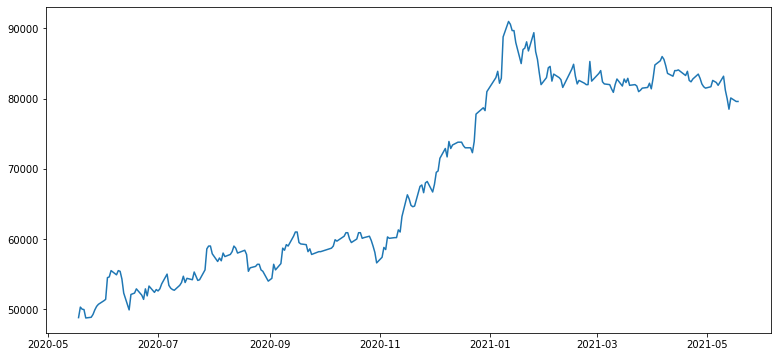

In [4]:
plt.plot(ts)

# Step 2. 각종 전처리 수행 
- 결측치 처리
- 로그 변환

### 결측치 처리

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 로그 변환
- 분산이 커지는 것을 방지

In [6]:
# 로그 변환
ts_log = np.log(ts)

# Step 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 정성적 그래프 분석
Rolling Statistics(구간 통계치)

- 구간의 평균(rolling mean, 이동평균)
- 표준편차(rolling std, 이동표준편차)

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylim([min(timeseries)-0.1, max(timeseries)+0.1])
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

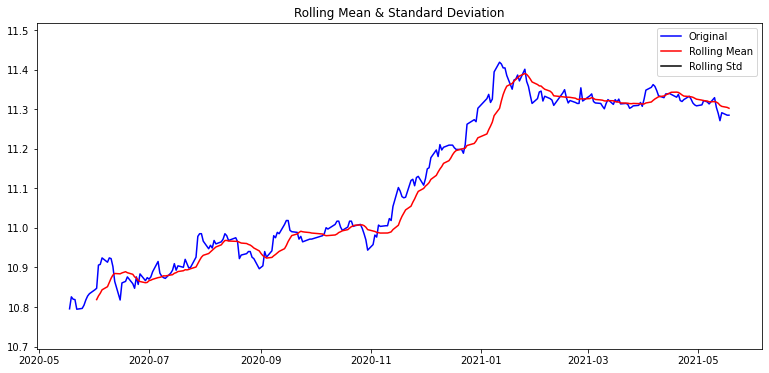

In [8]:
plot_rolling_statistics(ts_log, window=12)

### 정량적 Augmented Dicky-Fuller Test

In [9]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 시계열 분해(Time Series Decomposition)

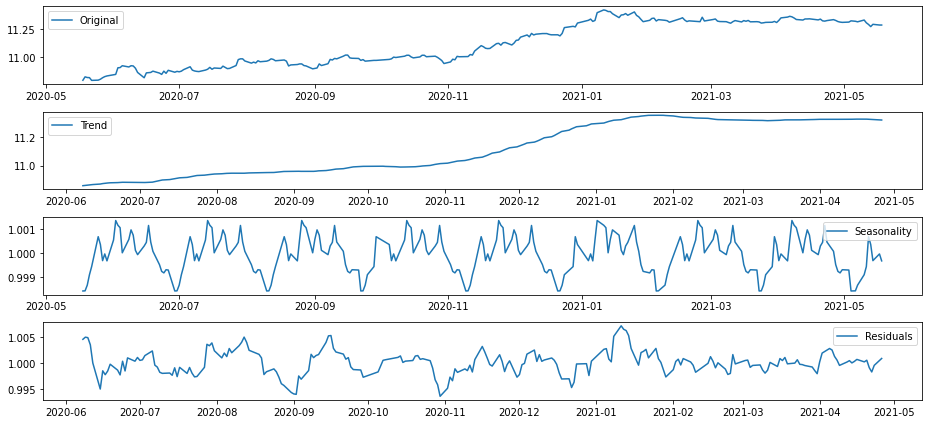

In [11]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인
- residual: original에서 trend, seasonality를 제거한 나머지

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# Step 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

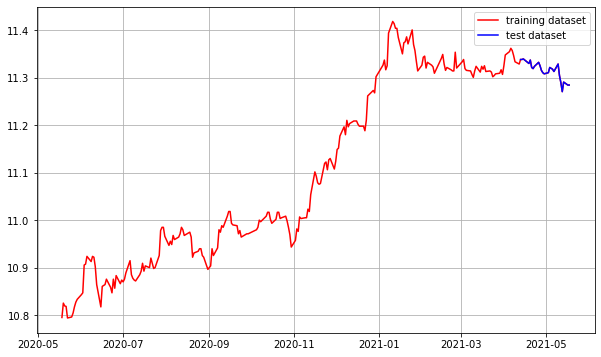

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# Step 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q구하기
- 차분 안정성 확인 -> d 구하기

### ACF

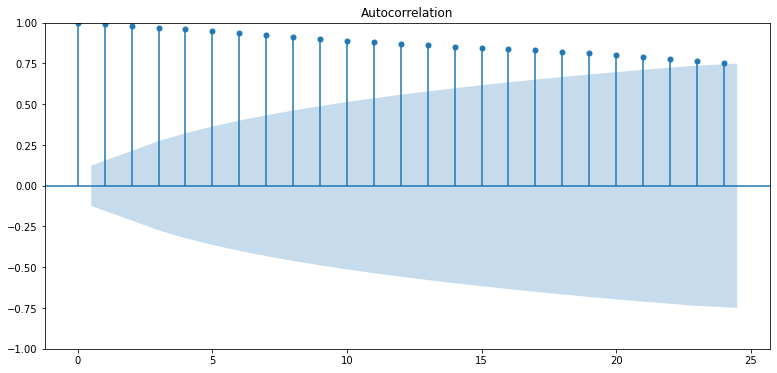

In [14]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plt.show()

### PACF

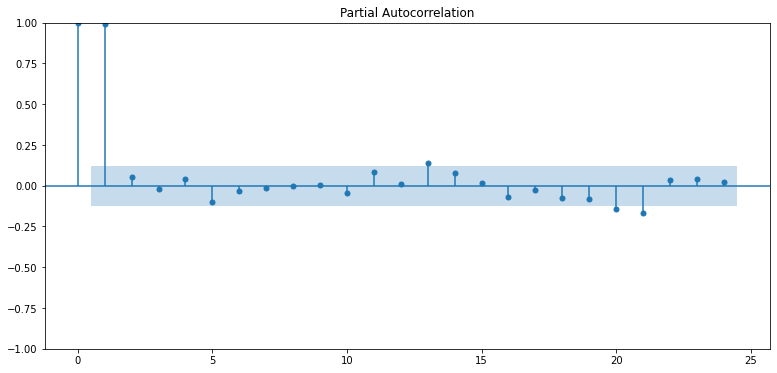

In [15]:
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 차분 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


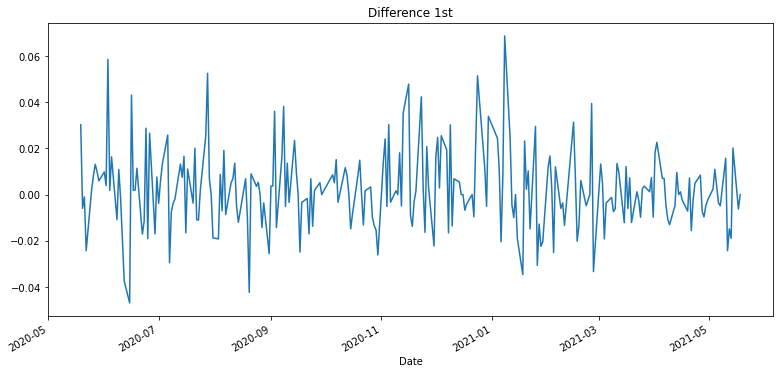

In [16]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


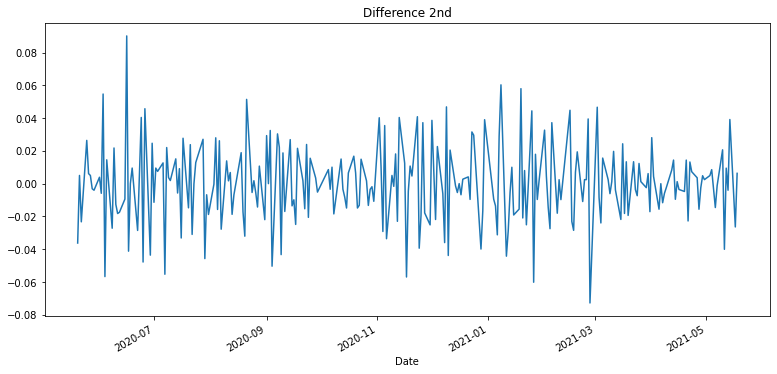

In [17]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# Step 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

### ARIMA 모델 빌드와 훈련

In [18]:
# Build Model
model = ARIMA(train_data, order=(10, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(10, 0, 1)   Log Likelihood                 585.584
Date:                Thu, 10 Feb 2022   AIC                          -1145.168
Time:                        07:22:17   BIC                          -1100.758
Sample:                             0   HQIC                         -1127.244
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0373      0.152     72.701      0.000      10.740      11.335
ar.L1          0.5736      0.554      1.035      0.301      -0.513       1.660
ar.L2          0.4210      0.572      0.735      0.4

### 모델 테스트 및 플로팅

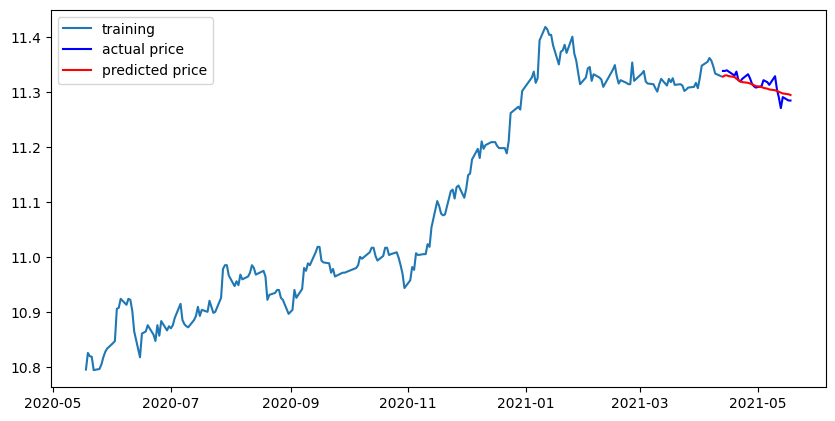

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [20]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  833605.9462066683
MAE:  718.9693778317398
RMSE:  913.0202331858086
MAPE: 0.88%


# Step 7. 다른 주식 종목 예측해 보기
- AAPL: apple
- FB: facebook
- TSLA: tesla

- Step 1. 시계열 데이터 준비
- Step 2. 각종 전처리 수행
- Step 3. 시계열 안정성 분석
- Step 4. 학습, 테스트 데이터셋 생성
- Step 5. 적정 ARIMA 모수 찾기
- Step 6. ARIMA 모델 훈련과 테스트

### 시계열 데이터 준비

In [21]:
filenames = ['AAPL', 'FB2A.BE', 'TSLA']

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
AAPL = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_AAPL = AAPL['Close']

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/FB2A.BE.csv'
FB = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_FB = FB['Close']

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
TSLA = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_TSLA = TSLA['Close']

In [22]:
tss = [ts_AAPL, ts_FB, ts_TSLA]

In [23]:
for ts in tss:
    print(ts.head())

Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64
Date
2021-02-10    222.300003
2021-02-11    222.699997
2021-02-12    222.699997
2021-02-15    222.050003
2021-02-16    226.300003
Name: Close, dtype: float64
Date
2021-02-10    804.820007
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
2021-02-17    798.150024
Name: Close, dtype: float64


### 각종 전처리 수행

In [24]:
# 결측치 처리
for ts in tss:
    ts = ts.interpolate(method='time')
    print(ts[ts.isna()])  

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


In [25]:
ts_logs = []
# 로그 변환
for ts in tss:
    ts_logs.append(np.log(ts))

### 시계열 안정성 분석

In [26]:
def t(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

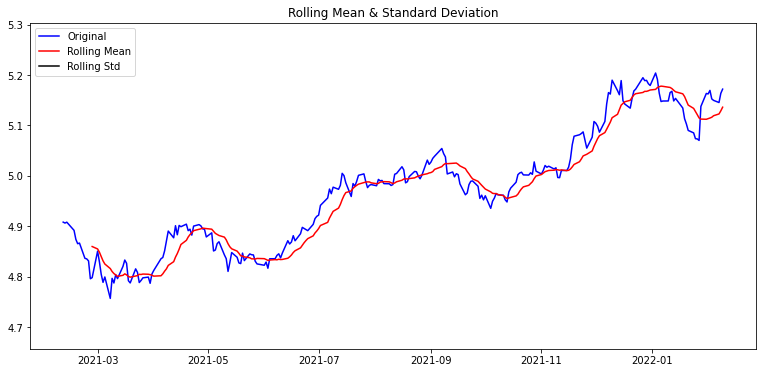

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


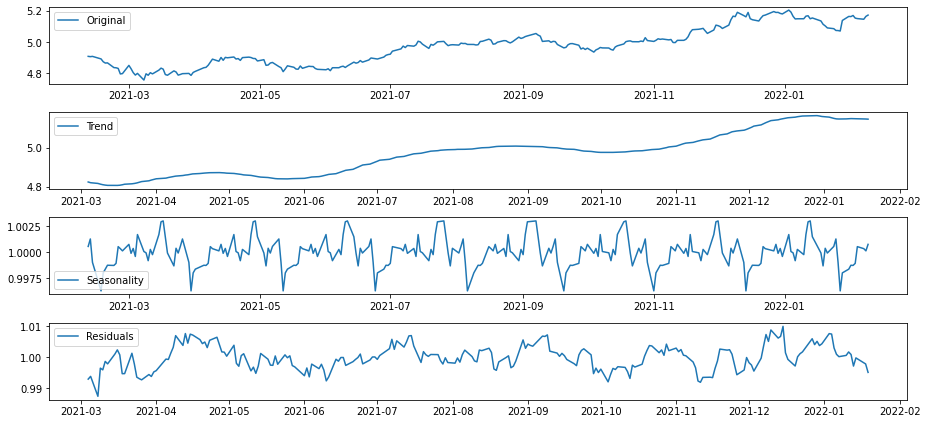

In [27]:
t(ts_logs[0])

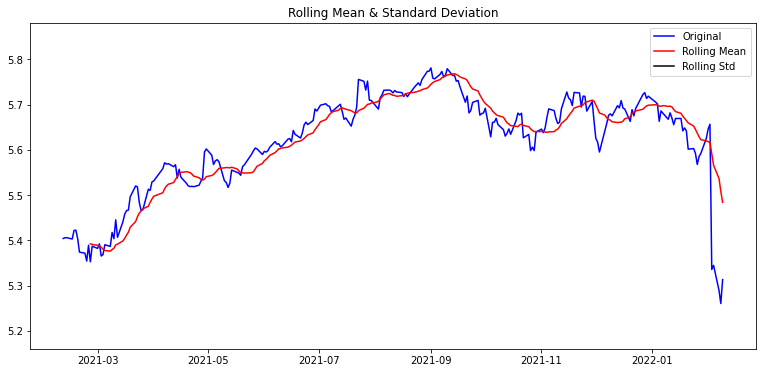

Results of Dickey-Fuller Test:
Test Statistic                  -1.540761
p-value                          0.513260
#Lags Used                       0.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


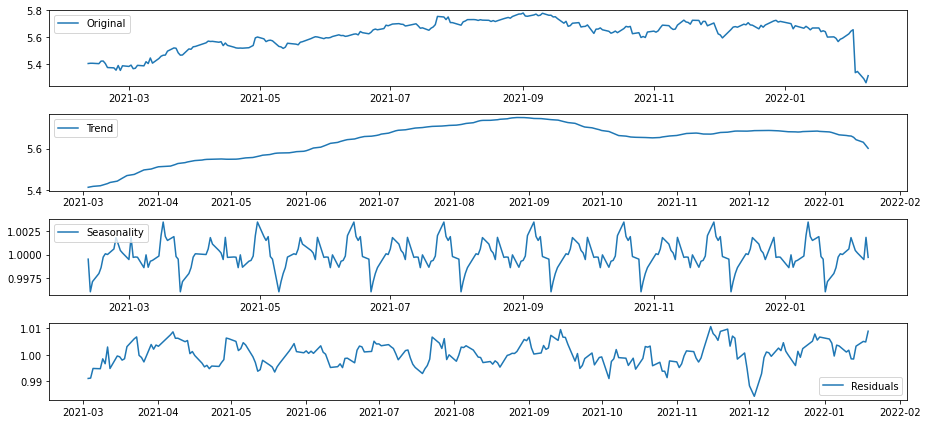

In [28]:
t(ts_logs[1])

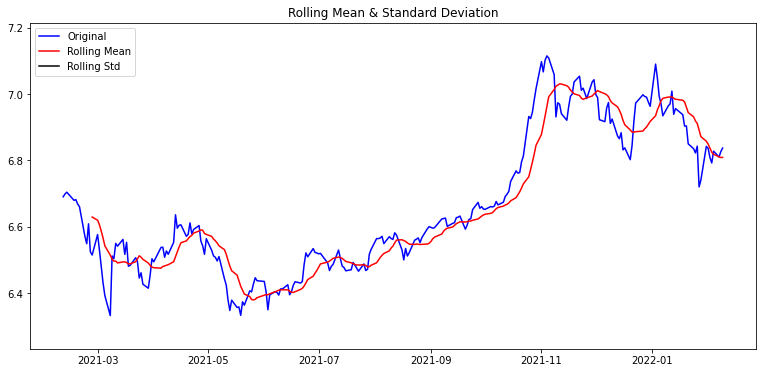

Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


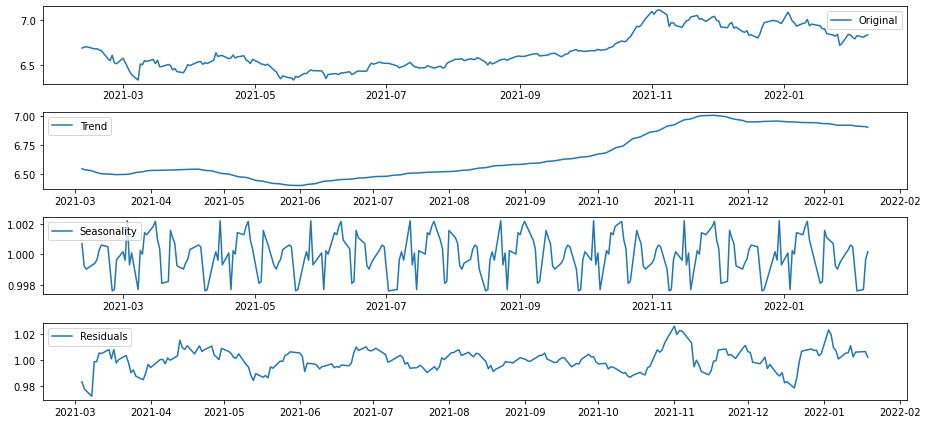

In [29]:
t(ts_logs[2])

### 학습, 테스트 데이터셋 생성

In [30]:
def train_test(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

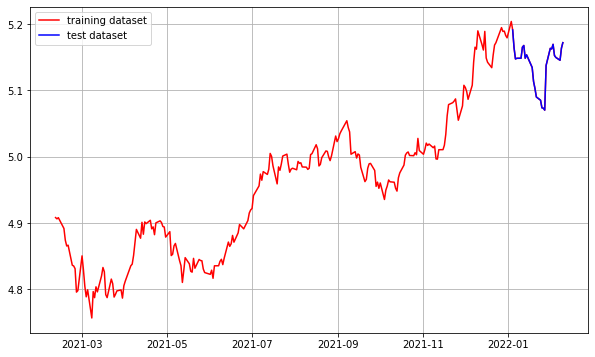

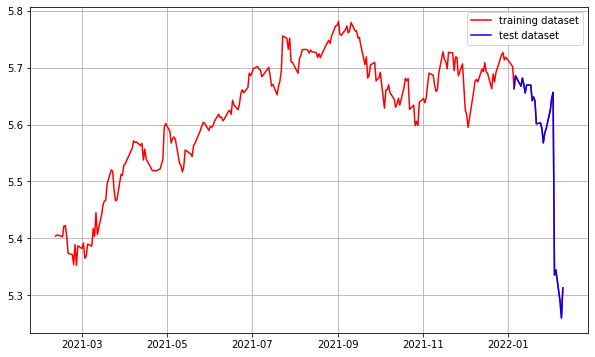

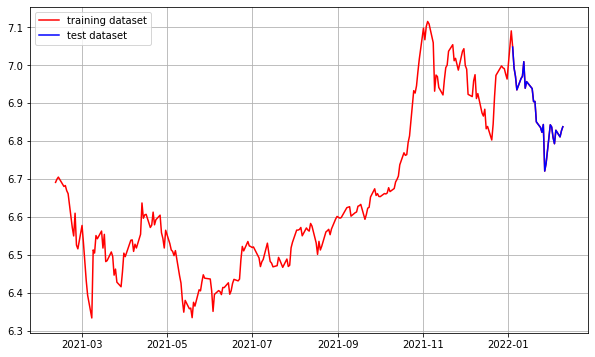

In [31]:
dataset = []
for ts_log in ts_logs:
    dataset.append(train_test(ts_log))

### 적정 ARIMA 모수 찾기

In [32]:
def acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

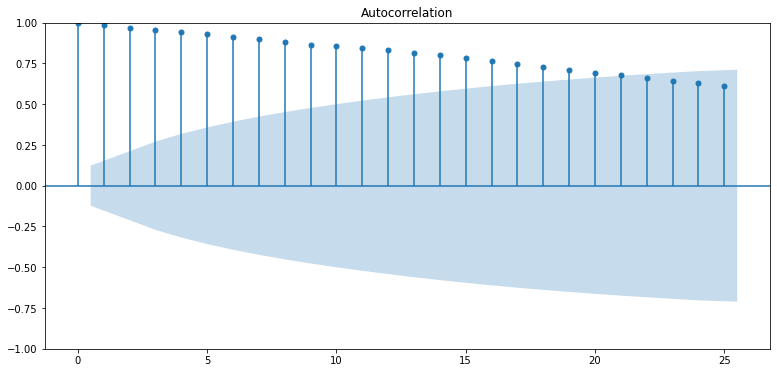

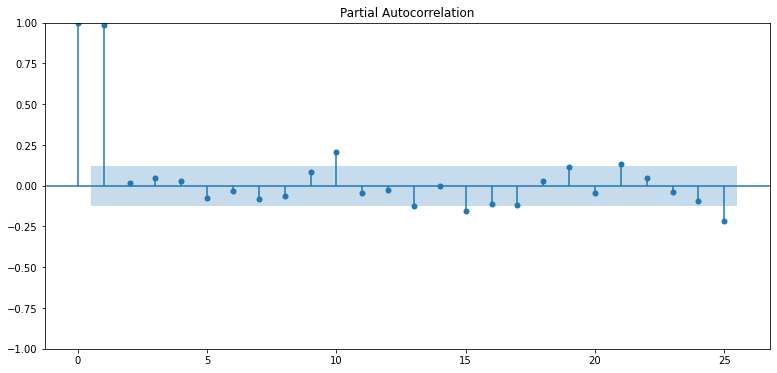

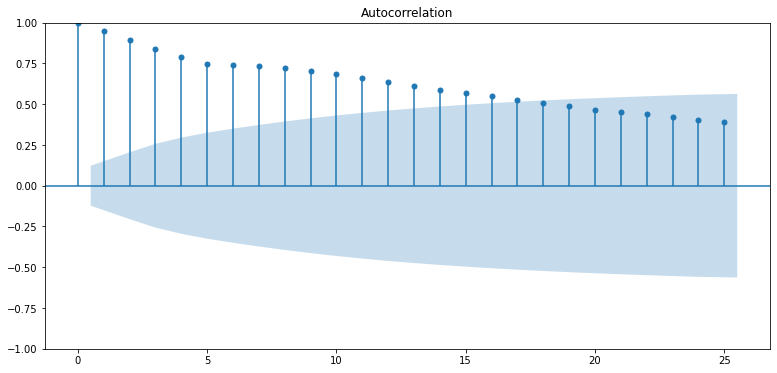

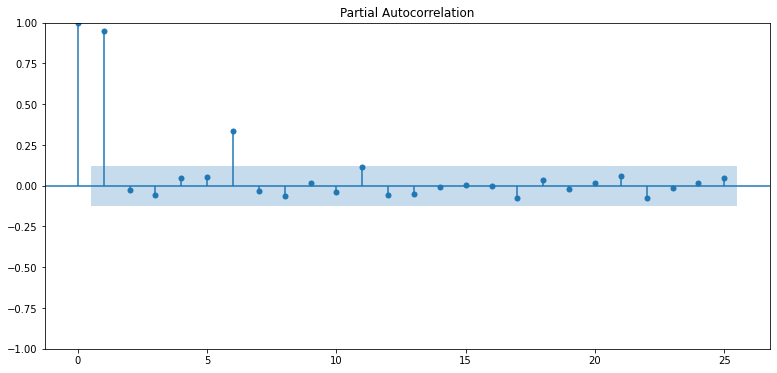

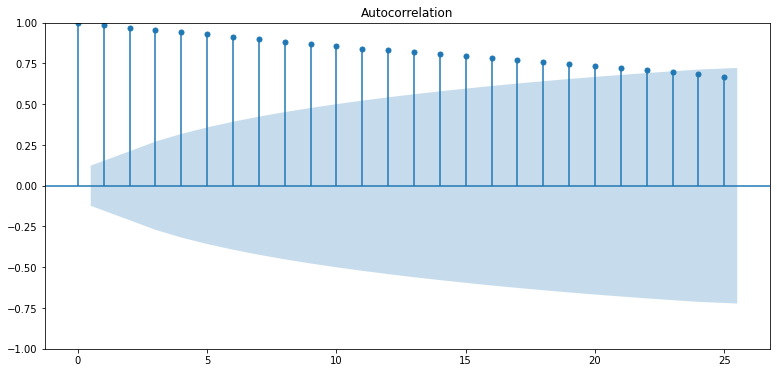

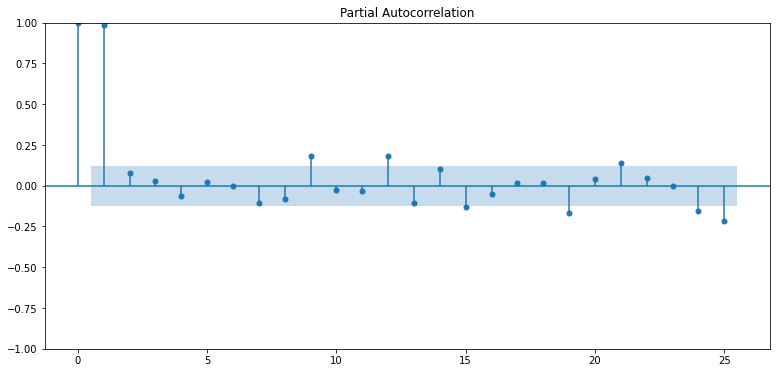

In [33]:
for ts_log in ts_logs:
    acf_pacf(ts_log)

In [34]:
def differencing(ts_log):
    # 1차 차분 구하기
    print('1차 차분')
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)
    
    print('\n2차차분')
    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)

1차 차분
Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64

2차차분
Results of Dickey-Fuller Test:
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


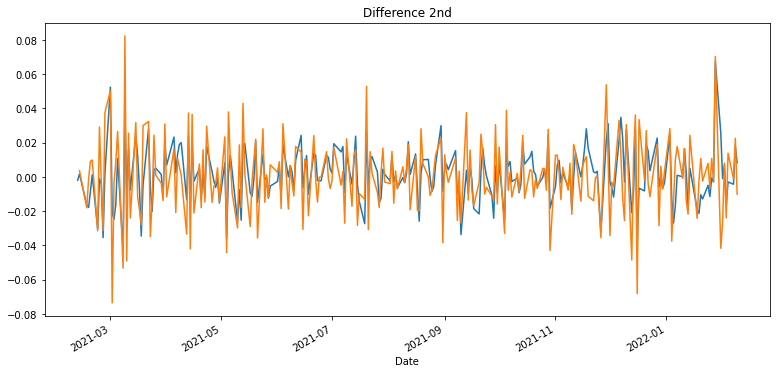

In [35]:
differencing(ts_logs[0])

1차 차분
Results of Dickey-Fuller Test:
Test Statistic                -8.937834e+00
p-value                        9.428444e-15
#Lags Used                     3.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64

2차차분
Results of Dickey-Fuller Test:
Test Statistic                -8.678934e+00
p-value                        4.338970e-14
#Lags Used                     1.000000e+01
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


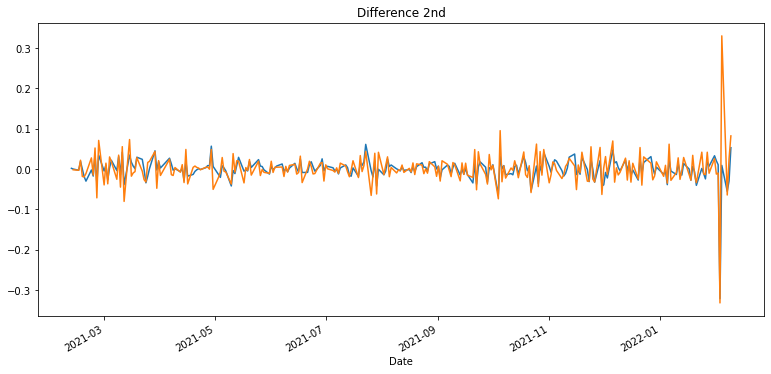

In [36]:
differencing(ts_logs[1])

1차 차분
Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64

2차차분
Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


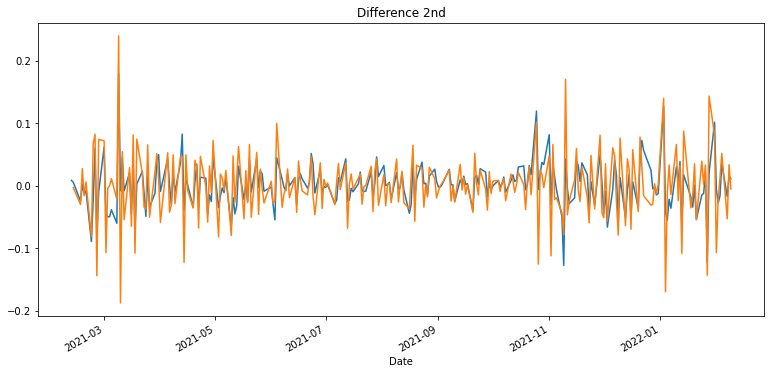

In [37]:
differencing(ts_logs[2])

### ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련

In [38]:
fitted_ms = []

# Build Model
model1 = ARIMA(dataset[0][0], order=(6, 0, 1))  
model2 = ARIMA(dataset[1][0], order=(11, 0, 1))  
model3 = ARIMA(dataset[2][0], order=(25, 0, 1))  

fitted_ms.append(model1.fit())
fitted_ms.append(model2.fit())
fitted_ms.append(model3.fit()) 

for fitted_m in fitted_ms:
    print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 623.863
Date:                Thu, 10 Feb 2022   AIC                          -1229.726
Time:                        07:22:41   BIC                          -1198.902
Sample:                             0   HQIC                         -1217.288
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0784      0.054     94.786      0.000       4.973       5.183
ar.L1          0.2735      0.890      0.307      0.759      -1.471       2.018
ar.L2          0.7349      0.924      0.795      0.4

모델 테스트 및 플로팅

In [39]:
def forecast(fitted_m, train_data, test_data):
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

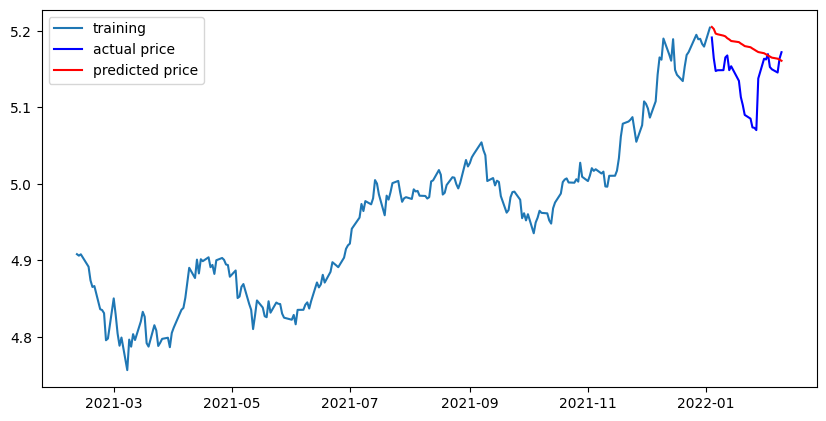

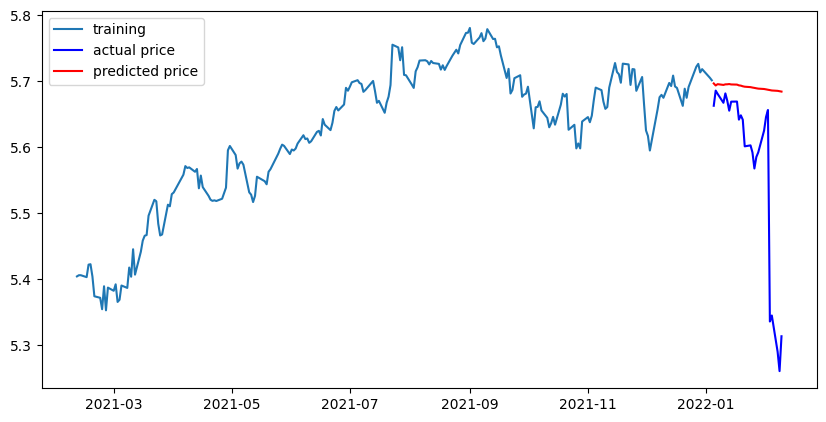

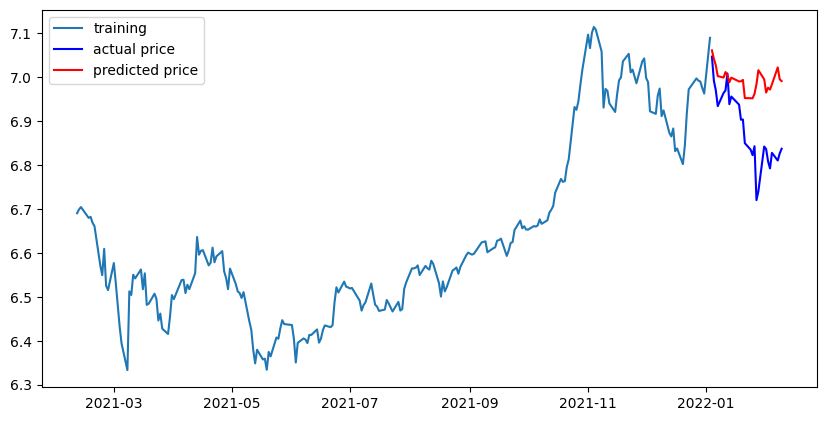

In [40]:
fc_list = []
for i, fitted_m in enumerate(fitted_ms):
    fc_list.append(forecast(fitted_m, dataset[i][0], dataset[i][1]))

최종 예측 모델 정확도 측정(MAPE)

In [41]:
def accuracy(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

In [42]:
for i, fc in enumerate(fc_list):
    print(filenames[i])
    accuracy(dataset[i][1], fc)
    print('\n')

AAPL
MSE:  85.81337933958213
MAE:  7.395184719199106
RMSE:  9.263551119283692
MAPE: 4.45%


FB2A.BE
MSE:  1899.1915674628488
MAE:  29.848917733235467
RMSE:  43.57971509157499
MAPE: 13.20%


TSLA
MSE:  17366.982555328195
MAE:  112.90530798467904
RMSE:  131.78384785446278
MAPE: 12.18%




___
# 프로젝트 정리

## 결과 분석 
주식|p|q|d|MAPE
---|---|----|---|---|
samsung|10|0|1|0.88%
apple|6|0|1|4.45%
facebook|11|0|1|13.20%
tesla|25|0|1|12.18%

## 어려웠던 점 
- 노드에서 진행 했던 데이터들은 그래프로 보았을 때 눈으로만 봐도 일련의 규칙이 존재하는 것이 보였는데 주식데이터는 그런것 없이 하다보니 너무 어려웠습니다.
- 또한 p, q, d를 설정하는 것이 너무 어려웠고 이론적인 측면에서도 너무 어려웠습니다.